I received an email a few weeks ago from my friend [Sean Gallen](https://sites.google.com/site/theseanswebsite/) asking about Bayesian modeling of critical wedges, in order to really explore the relationship between fault strength and tectonic stress. As it was a far more interesting use of my afternoon than my actual responsibilities (slogging through the paper I was writing), I of course dropped everything and went to work.

Sean was interested in a form of the [critical wedge][cw] model from [Suppe (2007)][suppe2007]. The full critical wedge equation from [Dahlen (1990)][d90]: 

$$ \alpha + \beta = \frac{\beta[1-(\rho_f / \rho)] + \mu_b(1-\lambda_b) + S_b / \rho g H}
{[1-(\rho_f / \rho)] + 2(1-\lambda) \left[\frac{\sin \phi}{1 - \sin \phi }\right] + C / \rho g H} $$

where $\alpha$ is the wedge surface slope, $\beta$ is the basal thrust (decollement) slope), $\rho$ is rock density, $\rho_f$ is the density of the fluid surrounding the wedge (air or water), $\mu_b$ is the coefficient of friction of the basal thrust, $\lambda$ is the pore fluid pressure in the wedge normalized by depth (i.e. $\rho g H$), $\lambda_b$ is the pore pressure of the decollement, $\phi$ is the angle of internal friction, $S_c$ is the basal cohesion/plasticity, and $C$ is the uniaxial compressive strength of the wedge.

Suppe consolidates the equation by gathering several terms into $F = \mu_b(1-\lambda_b) + S_b / \rho g H$ and $W = 2 ( 1 - \lambda) [\sin \phi / (1 - \sin \phi)] + C / \rho g H$. $F$ represents fault strength and $W$ represents the wedge strength. Since the model is at critical (Coulomb) failure, these terms also represent stresses: $F = \sigma_\tau / \rho g H$ and $W = (\sigma_1 - \sigma_3) / \rho g H$.

[cw]: https://en.wikipedia.org/wiki/Critical_taper
[suppe2007]: ftp://ftp.gps.caltech.edu/pub/avouac/Ge277-2010/Suppe-Geology-2007.pdf
[d90]: https://www.geophysik.uni-muenchen.de/~malservisi/LITHO/papers/DahlenAnnurev.pdf

This consolidation allows us to simplify the big equation above into a linear relationship between the surface slope $\alpha$ and the decollement slope $\beta$,

$$ \alpha = \frac{F}{\left[1 - (\rho_f / \rho) \right] + W} - \frac{W}{\left[1-(\rho_f / \rho)\right]+W}\beta $$

which is of the form $y = m  x + b$, i.e. a line.

Suppe uses this linear relationship with sets of ($\alpha$, $\beta$) measurements from a few active wedges to estimate $F$ and $W$ through linear regression. This is a good approach if you have multiple sets of $\alpha$ and $\beta$ measurements for a single wedge that have a bit of variation and a linear relationship.

However, this isn't exactly our problem. We are more interested in a single transect (with one value for $\alpha$ and $\beta$) and finding out how $F$ and $W$ covary. Furthermore, Sean has insightfully noted that calculating $\alpha$ directly from DEM-derived slope data is problematic, because you either have to filter/smooth the topography data or you just get really noisy $\alpha$ measurements. However, you can instead take a value for $\alpha$ and then predict the elevation at a point in the wedge, and compare that to the real elevation, which eliminates a lot of the messiness.

So we're going to work on that. We could definitely do this for multiple transects in a wedge, especially if we have good data from somewhere on the basal detachment geometry, and really try to pin down $F$ and $W$ as Suppe did. But that's a blog post for a different day.

If I had any (regular?) readers of this blog, these fictional persons would surely realize by now that we're going to do all of this with Python in a Jupyter notebook. The notebook is available [here][notebook_gist] and the underlying data are [here][data_gist] and [here][transect_gist].  You will need to change the paths specified below to wherever you download the files to run the notebook.

[notebook_gist]: https://gist.github.com/cossatot/bb042e307e21134adba497179ca7f35e
[data_gist]: https://gist.github.com/cossatot/aaa364a4244b5ee3264415208addaf31
[transect_gist]: https://gist.github.com/cossatot/8b8f4aa5fa82761c5f4478cc7eb199bd

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
import time
import numpy as np
from scipy.stats.mstats import gmean
import matplotlib.pyplot as plt
import pandas as pd
import pyproj as pj

In [3]:
from multiprocessing import Pool

In [4]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

## Load topographic data

First we're going to get the data.

### Load transect points

The transect is a line normal to the Himalayan wedge, running through some locally high topography. Then, I used a 0.3° buffer around it to extract points from the 250 m SRTM dataset. We will use these points to find the *x* axis for the analysis as well.

In [5]:
with open('../data/transect_line.geojson', 'r') as f:
    transect_pts_gj = json.load(f)
    transect_coords = transect_pts_gj['features'][0]['geometry']['coordinates']
                       
transect_pts = pd.DataFrame(data=transect_coords,
                            columns=['lon', 'lat'],
                            index=['p1', 'p2'])

In [6]:
transect_pts # these are the end points of the line.

,lon,lat
p1,86.726076,28.316242
p2,86.227448,26.592723


In [7]:
# convert to utm45

utm45 = pj.Proj(init='epsg:32645')
wgs84 = pj.Proj(init='epsg:4326')

transect_pts['easting'], transect_pts['northing'] = pj.transform(wgs84, utm45,
                                                                 transect_pts['lon'].values,
                                                                 transect_pts['lat'].values)

In [8]:
transect_pts

,lon,lat,easting,northing
p1,86.726076,28.316242,473146.100052,3.132265e+06
p2,86.227448,26.592723,423075.501911,2.941559e+06


Now we're going to read in a topography [dataset][topo_data], in .csv format, with Pandas

[topo_data]: https://gist.github.com/cossatot/aaa364a4244b5ee3264415208addaf31

In [9]:
topo_pts = pd.read_csv('../data/himalaya_topo_data_wgs84.csv',
                       names=['lon', 'lat', 'elev'])

Look at the end of the data file:

In [10]:
topo_pts.tail()

,lon,lat,elev
312103,86.239065,26.294209,57
312104,86.241148,26.294209,55
312105,86.243232,26.294209,54
312106,86.245315,26.294209,56
312107,86.247398,26.294209,53


Now let's make a little plot:

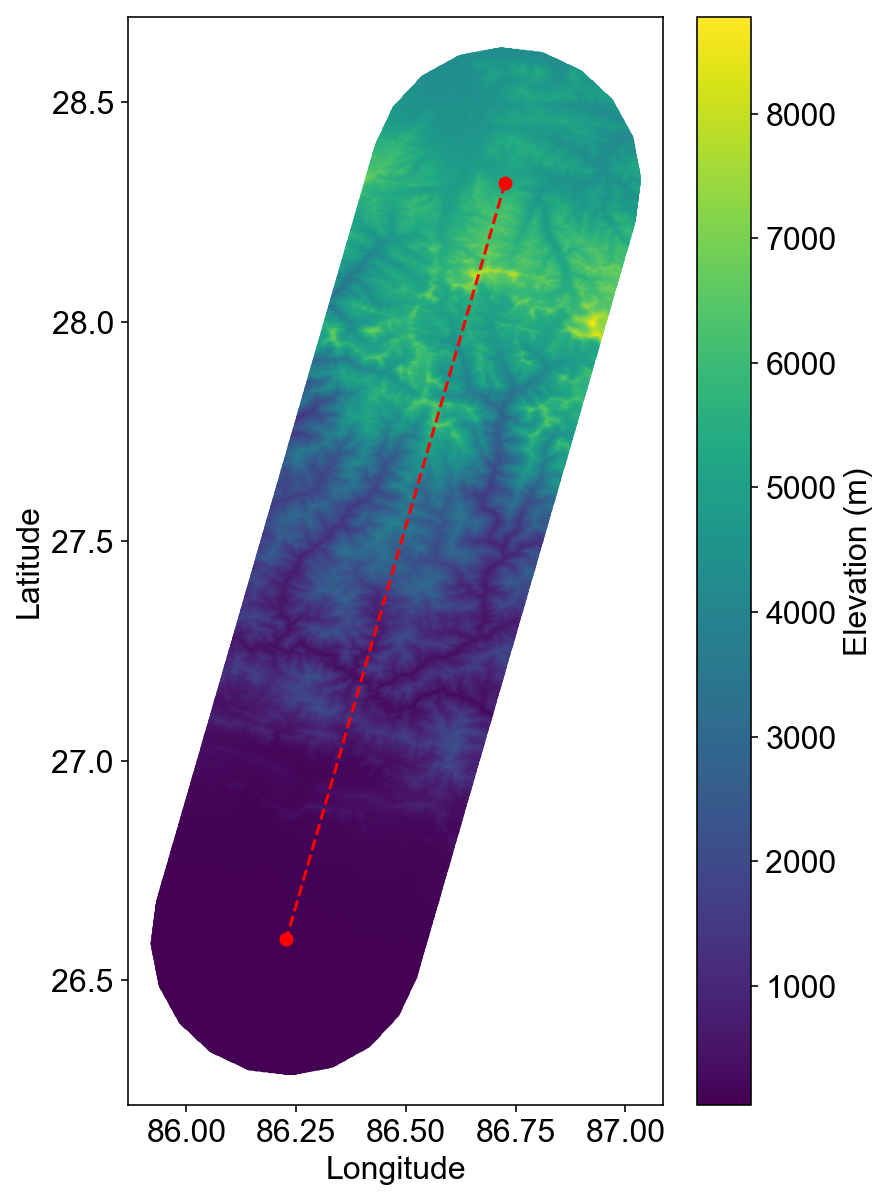

In [11]:
plt.figure(figsize=(6,10))
plt.scatter(topo_pts.lon, topo_pts.lat,
            c=topo_pts.elev,
            lw=0, s=20)
plt.plot(transect_pts['lon'], transect_pts['lat'], 'ro--')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Elevation (m)')
plt.axis('equal')
plt.show()

In [12]:
# Project these points into UTM 45N
topo_pts['easting'], topo_pts['northing'] = pj.transform(wgs84, utm45, 
                                                         topo_pts.lon.values,
                                                         topo_pts.lat.values)

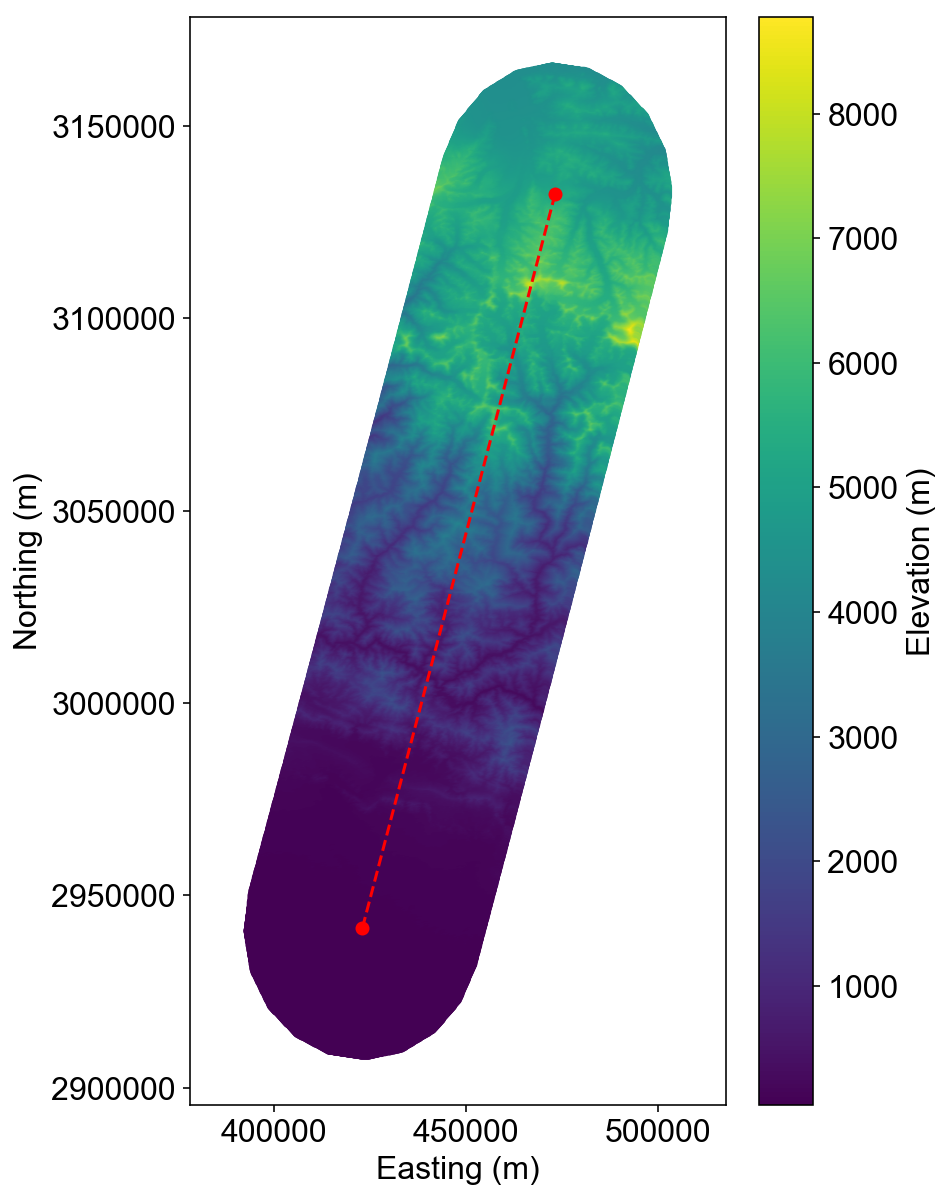

In [13]:
plt.figure(figsize=(6,10))
plt.scatter(topo_pts.easting, topo_pts.northing,
            c=topo_pts.elev,
            lw=0, s=20)

plt.plot(transect_pts['easting'], transect_pts['northing'], 'ro--')

plt.colorbar(label='Elevation (m)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.axis('equal')
plt.show()

### Rotating points to transect coordinates

The critical wedge model that we're using is in two dimensions, with the *x*-axis along the transect (i.e. the red line in the plots above) and the *y*-axis as elevation.  So we need to rotate and translate all of the points into this coordinate system, which will smash all of the lateral variation; the lateral variation then becomes the *y*-scatter in the data.

First we find the east and north coordinates in meters relative to the southern transect point, `p2`, which will be the new origin.

In [14]:
topo_pts['rel_east'] = topo_pts['easting'] - transect_pts.loc['p2','easting']
topo_pts['rel_north'] = topo_pts['northing'] - transect_pts.loc['p2','northing']

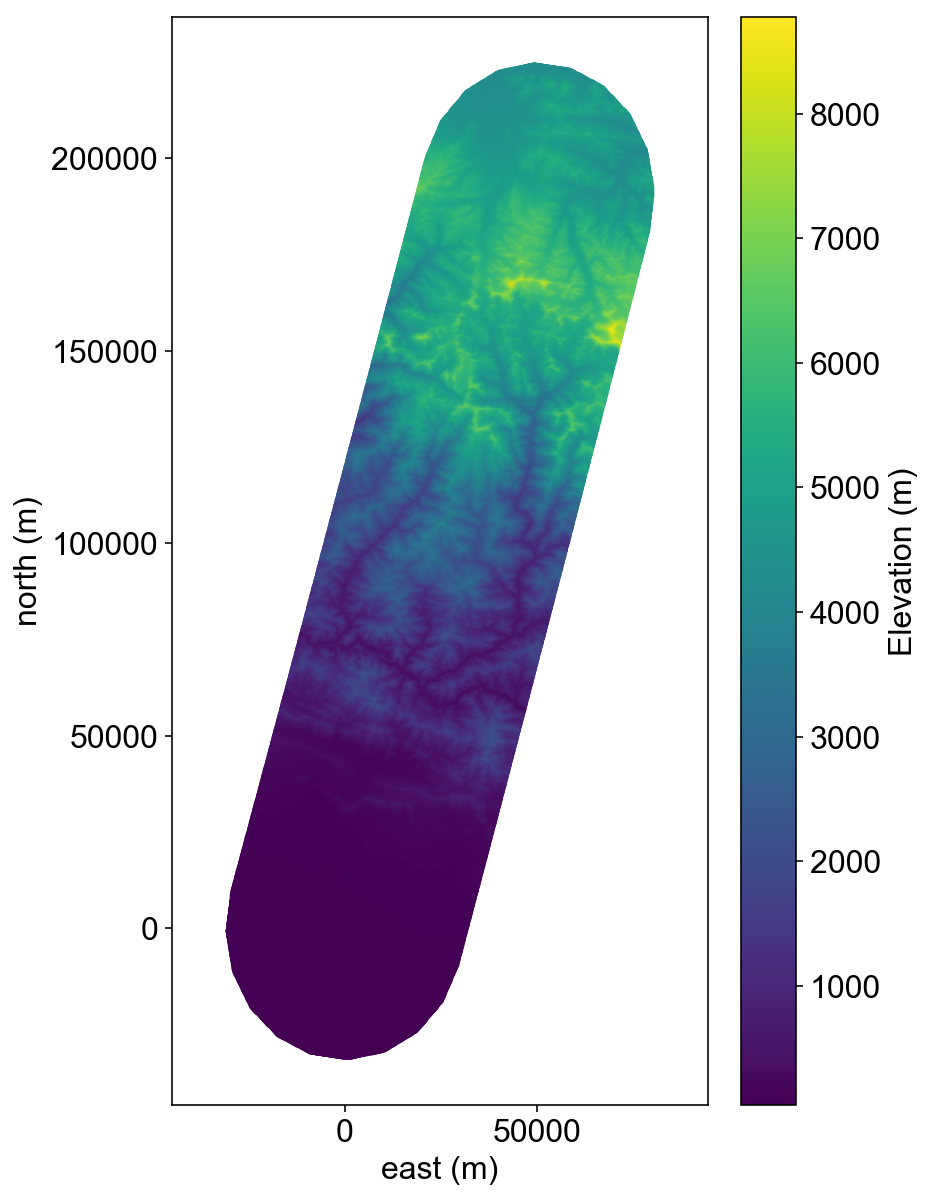

In [15]:
plt.figure(figsize=(6,10))
plt.scatter(topo_pts.rel_east, topo_pts.rel_north,
            c=topo_pts.elev,
            lw=0, s=20)


plt.colorbar(label='Elevation (m)')
plt.xlabel('east (m)')
plt.ylabel('north (m)')
plt.axis('equal')
plt.show()

Then we find the rotation angle (which rotates the transect to the *x*-axis), and do the rotation as a matrix mutliplication.

In [16]:
tran_angle = np.arctan2((transect_pts.loc['p1','northing']
                         -transect_pts.loc['p2','northing']),
                       (transect_pts.loc['p1','easting']
                        -transect_pts.loc['p2','easting']))

rot_angle = -tran_angle

In [17]:
rot_angle

-1.3140380682025581

In [18]:
# rotation matrix
R = np.array([[np.cos(rot_angle), -np.sin(rot_angle)],
              [np.sin(rot_angle),  np.cos(rot_angle)]])

# do the rotation
rot_pts = np.dot(R, topo_pts[['rel_east', 'rel_north']].values.T)

# add pts back to dataframe
topo_pts['x'] = rot_pts[0,:]
topo_pts['y'] = rot_pts[1,:]

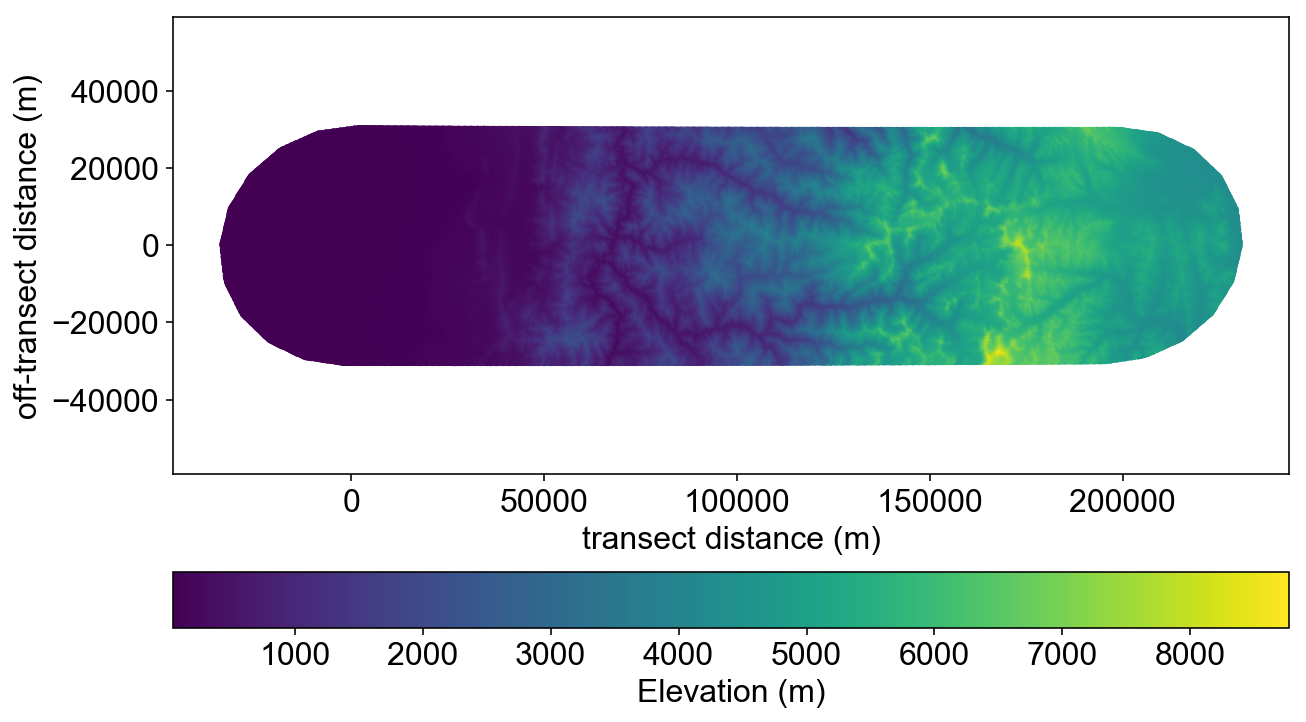

In [19]:
plt.figure(figsize=(10,6))
plt.scatter(topo_pts.x, topo_pts.y,
            c=topo_pts.elev,
            lw=0, s=20)

plt.colorbar(orientation='horizontal', label='Elevation (m)')
plt.xlabel('transect distance (m)')
plt.ylabel('off-transect distance (m)')
plt.axis('equal')
plt.show()

Sweet! Now let's look at the data in a vertical cross-section:

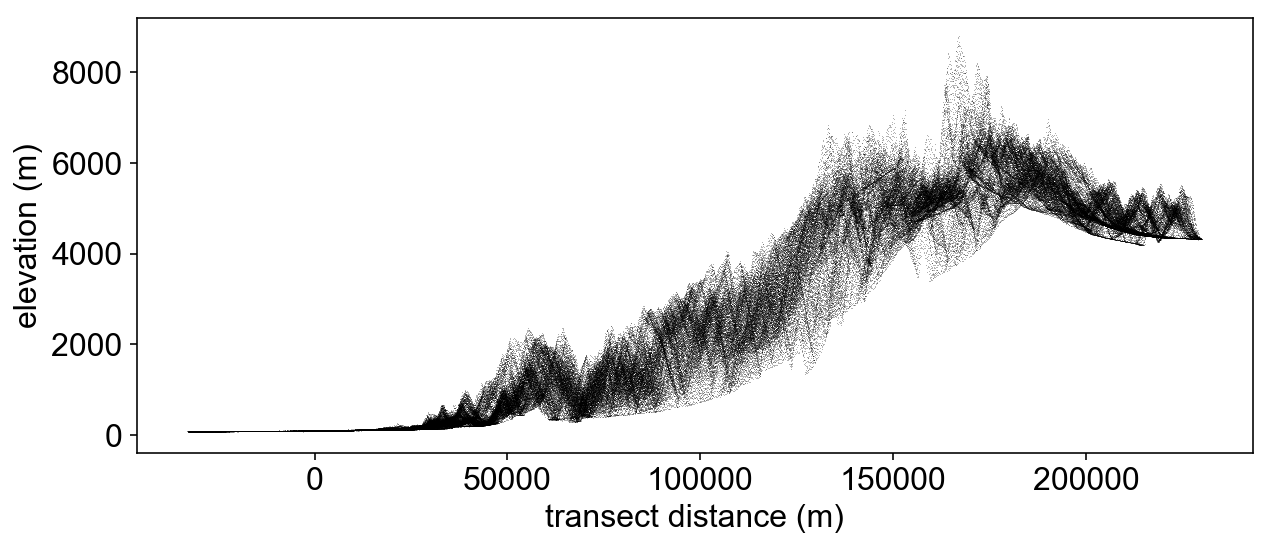

In [20]:
plt.figure(figsize=(10,4))

plt.plot(topo_pts.x, topo_pts.elev, 'k,', alpha=0.3)
plt.xlabel('transect distance (m)')
plt.ylabel('elevation (m)')
plt.show()

Looks like a swath profile through a wedge to me.

## Finding Critical Wedge parameters

Ok, now that we've gotten the data loaded, let's fit the model to it.

We're going to do a Bayesian inversion for $F$ and $W$ given topography data $d$. In this inversion, we'll take values for $F$ and $W$, and then ascribe a likelihood to each $(F,W)$ combination based on the match between predicted and observed topography.

I will get into the nuts and bolts of the inversion later, but the fundamental equation here is Bayes' rule:

$$ p(F,W \, | \, d) \propto p(F,W) \cdot p(d\, | \, F,W)$$

where $p(F,W \, | \, d)$ is the *posterior probability* (or just *posterior(s)*) of $F$ and $W$ given the data $d$, $p(F,W)$ is the *prior probability* (or *prior(s)*) of $F$ and $W$, and $p(d\, | \, F,W)$ is the *likelihood* of observing the data *d* given values of $F$ and $W$.

The likelihood compares model predictions vs. observations. We got the observations ready in the previous section, so now we need to make predictions.

### Slope <-> topography

As noted above, the equations relate $F$ and $W$ to $\alpha$ (and $\beta$), not to the elevation data.

Therefore, we'll have to predict the elevation at any point in the transect *x* by calculating $\alpha$ based on $F$ and $W$ and then using that slope with a point at the toe of the wedge to predict the elevation of the wedge at that point.

Note that I'm also fixing the decollement dip at 10°, and setting the fluid density to zero as it's a subareal wedge. I will stick with this for the remainder of the work, but you could change that based on the preferred fluid density and detachment dip.

In [21]:
def get_wedge_slope(F, W, detach_dip=np.radians(10),
                    fluid_density=0., rock_density=2.7):
    
    denominator = (1 - fluid_density / rock_density) + W
    
    alpha = (F - W * detach_dip) / denominator
    
    return alpha

In [22]:
def pred_elev(x, x_toe, wedge_slope):
    
    return np.tan(wedge_slope) * (x-x_toe)
    

I'm putting the toe of the wedge at 50,000 m from the transect start point, and setting the 'backstop' of the wedge at 175,000 m, based on eyeballing and rounding.

Let's see how the predicted wedge (in red) matches the real elevation points:

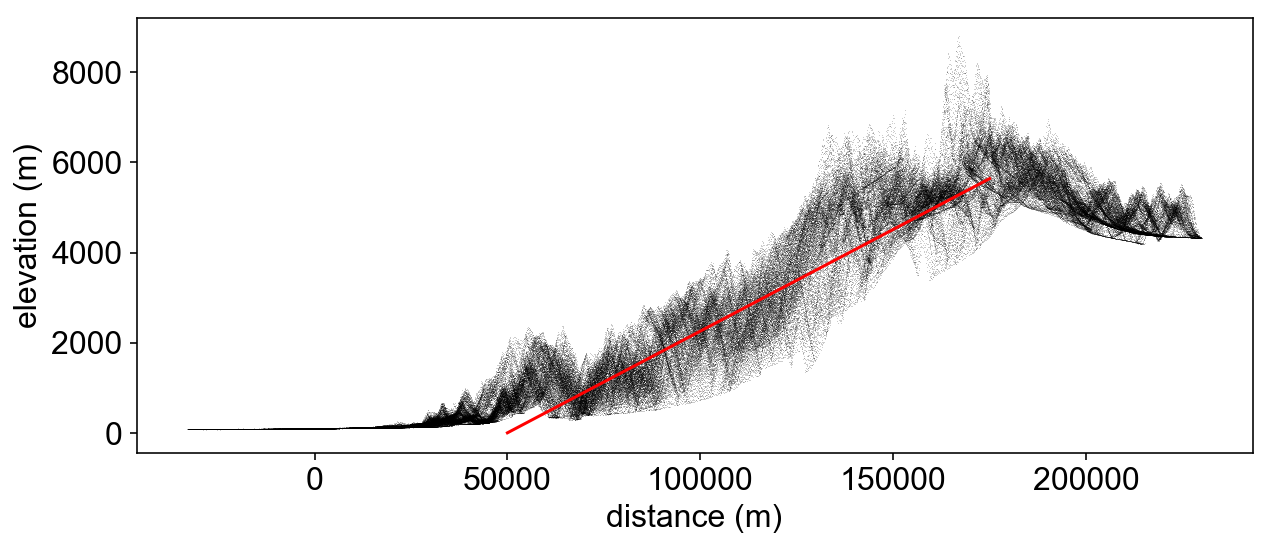

In [23]:
plt.figure(figsize=(10,4))

plt.plot(topo_pts.x, topo_pts.elev, 'k,', alpha=0.2)

plt.plot(np.linspace(50000,175000), 
         pred_elev(np.linspace(50000,175000),
                   50000,
                   get_wedge_slope(0.1, 0.25)),
         'r')

plt.xlabel('distance (m)')
plt.ylabel('elevation (m)')

plt.show()

Pretty nice!  We can see that but for some deviation in the Subhimalaya/Siwalik ranges and the High Himalaya, the wedge actually looks pretty linear.  This is good, and it wasn't something I was counting on beforehand.

### Estimating model error

Though the priors get all the hate (*"Bias! Bias!"*), they're often pretty intuitive. The likelihood function is a bit less so. It may be though of as calculting how likely is it that the data could be generated by the model (i.e. the parameters we're inverting for). This fits the conditional probability form, $p(d\,|\,m)$, the probability of the data $d$ given the model $m$. This is still kind of abstract at first, though with more exposure to Bayes it starts to make sense in a stimulating yet deep and satisfying way, warming your belly like a nice spicy doner kebap.

In practice though, the likelihood function is specified as a function of the misfit between the data and the model predictions; the smaller the misfit, the higher the likelihood. This tends to be crystal clear to people who have fit models to data before but lack a solid theoretical background in the process.

We'll define the actual likelihood function in a moment (spoiler alert: it's a Gaussian) but first we will make a function to calculate the observation error (i.e model - predictions).

In [24]:
def obs_error(x, y, x_toe, x_top, F, W):
    x_ = x[(x >= x_toe) & (x <= x_top)]

    wedge_slope = get_wedge_slope(F, W)
    
    pred_y = pred_elev(x_, x_toe, wedge_slope)
    
    error = y - pred_y
     
    return error

In [25]:
# testing with pretty-good fitting parameters
oe = obs_error(topo_pts.x, topo_pts.elev, 50000, 175000, 0.1, 0.25)

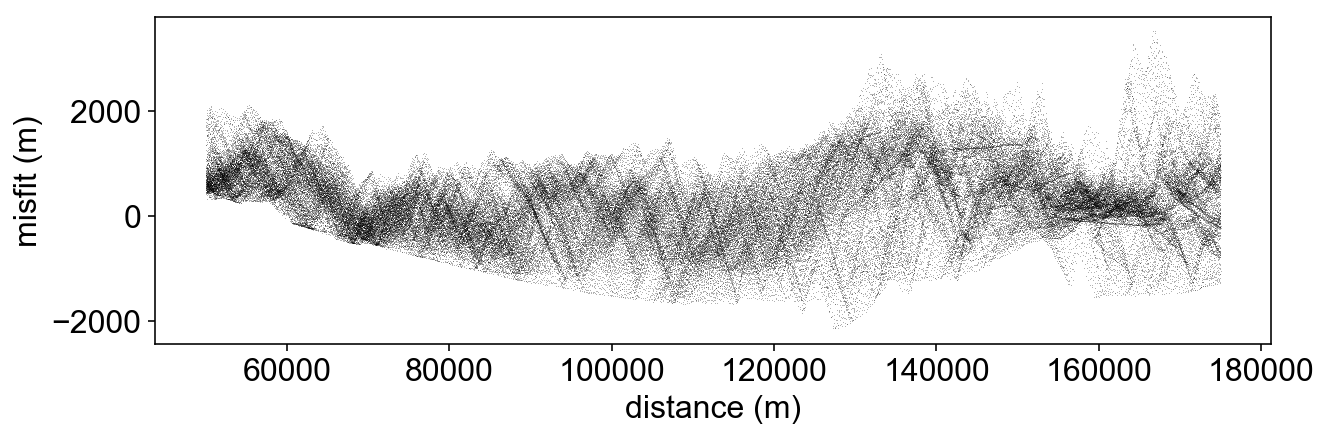

In [26]:
plt.figure(figsize=(10,3))

plt.plot(topo_pts.x, oe,
        'k,', alpha=0.3)

plt.xlabel('distance (m)')
plt.ylabel('misfit (m)')

plt.show()

In [27]:
oe.mean()

240.80273019738905

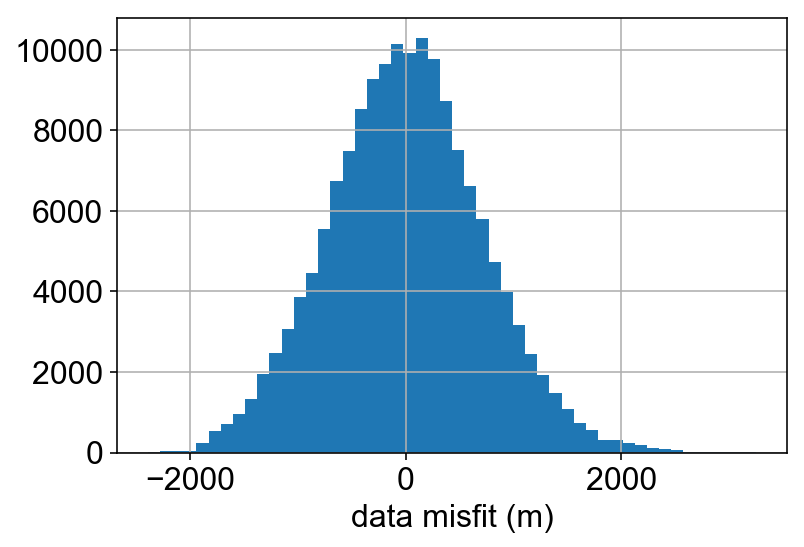

In [28]:
(oe-oe.mean()).hist(bins=50)
plt.xlabel('data misfit (m)')
plt.show()

We're going to define the model likelihood based on a Gaussian (normal) distribution.  I don't always like normal distributions, because very freqently data are not at all normally distributed, and by treating things as such you can miss a lot or be unduly influenced by the tails of the real data.

But look at that above!  This is pretty close, and the normal distribution is implied with a least-squares fit anyways, so I feel pretty good about it today.

First we need to estimate the standard deviation of the data variability:

In [29]:
# find approximate data variability
err = oe.std()

[TIMEOUT]

We have >300,000 data points. Though we can go ahead with the inversion with this much data, and I would if this were a publication, we can also speed things up tremendously by downsampling the data.  We'll just gather random samples from the data so as not to alias it.

In [30]:
# Downsample data (speeds up calculations)

topo_pts_d = topo_pts.sample(frac=0.01)

### Calculating the model likelihood

#### Single data point

The likelihood function we'll use is based on the [normal distribution][nd].  For a given data point $d$ and model parameters $m$, the likelihood is:

$$p(d\,|\,m) = \frac{1}{\sqrt{2 \pi \sigma^2}} 
\exp \left[- \frac{(d^{obs} - d^{mod})^2}{2 \sigma^2} \right] $$

where $ d^{obs}$ is the observed data point and $d^{mod}$ is the predicted data point, and $\sigma$ is the standard deviation of the data.

This equation takes the normal distribution with mean $d^{obs}$ and standard deviation $\sigma$ and then gives us the $y$ value of the distribution at $d^{obs} - d^{mod}$.

[nd]: https://en.wikipedia.org/wiki/Normal_distribution

In code:

In [31]:
def pt_likelihood(obs_err, err_=err):
    like_term_1 = 1 / np.sqrt(2 * np.pi * err**2)
    like_term_2 = np.exp(-(obs_err**2) / (2 * err_**2))
    
    return like_term_1 * like_term_2

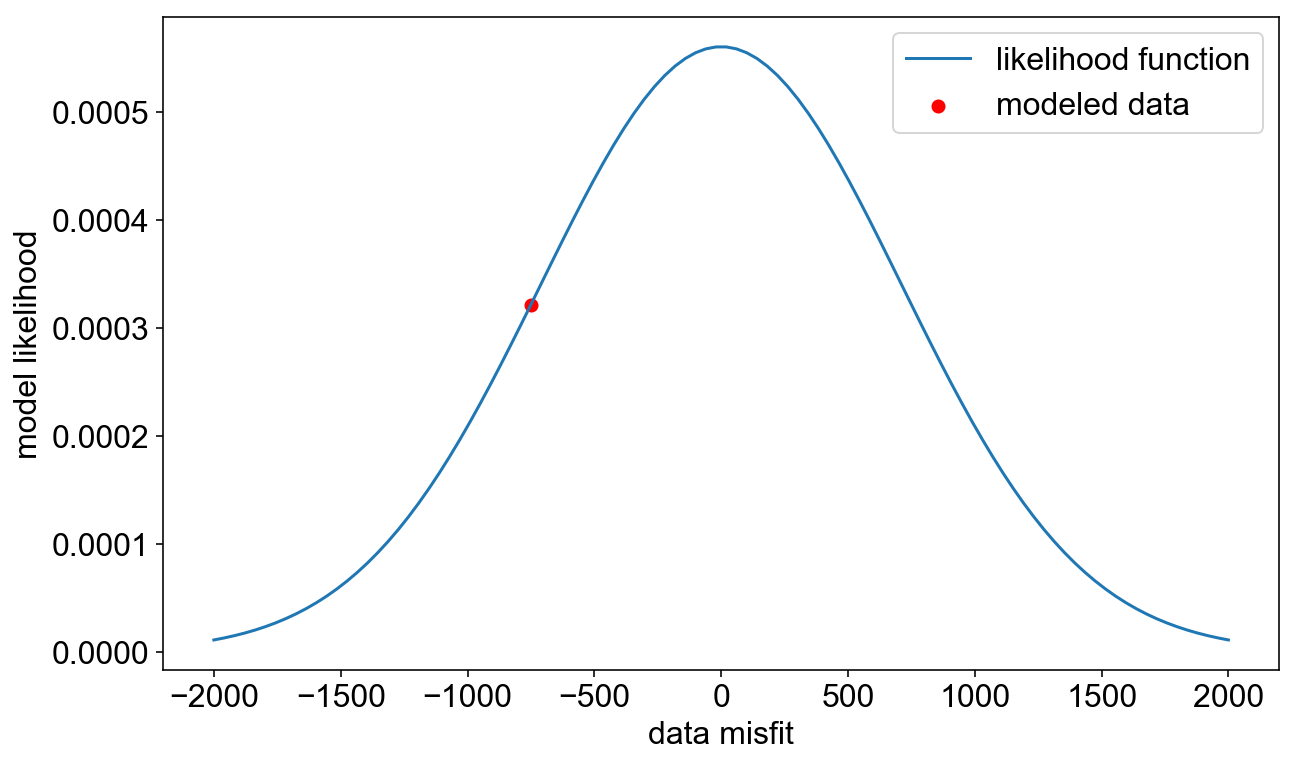

In [32]:
plt.figure(figsize=(10,6))

plt.plot(np.linspace(-2000, 2000, 100),
        pt_likelihood(np.linspace(-2000, 2000, 100)),
        label='likelihood function')

plt.scatter(-750, pt_likelihood(-750), 
            c='r', label='modeled data')

plt.xlabel('data misfit')
plt.ylabel('model likelihood')
plt.legend()

plt.show()

#### Likelihood for all data

Probability theory holds that the joint probability of independent events is the product of their individual (marginal) probabilities:

$$ p(a,b) = p(a) \cdot p(b) \;.$$

Following this, the total likelihood of *all* of the data is then the product of all of the likelihoods for each data point:

$$ p(d\,|\,m) = \prod_i^n p_i(d_i \,|\,m) \;, $$

because the misfit of any data point is independent of the misfit of the other data points.

Though this is the standard way of calculating model likelihoods in Bayesian inversions, in practice it actually penalizes you for having a lot of data. Because the individual likelihoods are small numbers (well below one for a perfect fit, according to the plot above), the total likelihood decreases exponentially with more data. Pretending that all of the likelihoods from a model are equal, then the total likelihood becomes $p(d\,|\,m)^n$.

With 300,000 data points, this becomes ridiculous. If all of the likelihoods are 0.999, the total likelihood is $0.999^{300000}$ = ~4.43e-131. That is well below values computers can comfortably do floating-point arithmetic with. It's an absurd number, especially for an essentially perfect fit to a shitload of data.

Therefore, the log-likelihood $\log(p(d\,|\,m)$ is commonly used instead, which ameliorates the problems of computational accuracy.

But this still bothers me as a scientist, even though it is theoretically sound. You shouldn't be penalized for more data, and a likelihood derived from a model with one $n$ can't be meaningfully compared to a likelihood derived from a model with a different $n$.

I've toyed around with different approaches in the past, but I've typically had a few hundred to a few thousand data in an inversion, and the problems weren't as pronounced.

But nevermore!  I have instead decided to start making likelihood functions that are normalized to the amount of data. Instead of the product of the individual data likelihoods, I just use the [geometric mean][gm]:


$$ p(d\,|\,m) = \left( \prod_i^n p_i(d_i \,|\,m) \right)^{1/n} = \sqrt[n]{p_1 \cdot p_2 \cdot \ldots \cdot p_{i-1} \cdot p_i} \;. $$

Unlike the arithmetic mean, this completely preserves the multiplicative properties arising from the independence of the individual likelihoods.

We'll code this up and run with it.

[gm]: https://en.wikipedia.org/wiki/Geometric_mean

In [33]:
def geom_mean_likelihood(obs_error, err_=err):
    in_bounds_errs = obs_error.dropna()
    
    likelihoods = pt_likelihood(in_bounds_errs, err_)
    
    return gmean(likelihoods)

In [34]:
def calc_likelihood(x, y, x_toe, x_top, F, W):
    
    return geom_mean_likelihood(obs_error(x, y, x_toe, x_top, F, W))

## Set up inversion

### Make priors

As stated earlier, Bayes' rule is:

$$ p(F,W\,|\,d) \propto p(F,W) \cdot p(d\,|\,F,W) \;.$$

We already went through the likelihood function. The other component (aside from the $\propto$ operator) is the prior probability distribution of our model parameters $F$ and $W$. 

The priors in this case are going to be quite simple. We're going to set $p(F) = [0,1)$ (it essentially the effective coefficient of friction, so it should probably be between 0 and 1 for rocks), and $p(W) = [0,3]$ (this is the differential tectonic stress normalized to lithostatic pressure; 3 is really high).

$p(W)$ and $p(F)$ are uniform distributions, and they are independent variables.  Therefore, $p(F,W)$ for any point that is within the above bounds is equal, so we don't need to worry about the exact value of it.

### Other inversion stuff

Our methods are Monte Carlo based. Basically what we'll do is sample $n$ samples from $p(W)$ and $p(F)$, calculate $\alpha$ for each of the $n$ sample sets, then calculate $p(d\,|\,F,W)$, and then 'sample the posterior' which I will describe below.

We'll do $N$ = 100,000 iterations. Because that is a lot, we will parallelize the likelihood calculations.  It will still take a minute or five to run, depending on your hardware.

In [35]:
n_iters = int(1e5)

x_toe = 50000   # front of the wedge
x_top = 175000  # back of the wedge

F_min = 0.
F_max = 1.

W_min = 0.
W_max = 3.

priors = pd.DataFrame(index=np.arange(n_iters), 
                      columns=['F', 'W', 'likelihood', 'rel_likelihood'])

np.random.seed(70)  # make sure the calculations are repeatable

priors['F'] = np.random.uniform(F_min, F_max, n_iters)
priors['W'] = np.random.uniform(W_min, W_max, n_iters)

In [36]:
priors.head()

,F,W,likelihood,rel_likelihood
0,0.927481,1.418750,NaN,NaN
1,0.872426,1.537132,NaN,NaN
2,0.584631,2.395302,NaN,NaN
3,0.905170,0.777661,NaN,NaN
4,0.316833,0.338925,NaN,NaN


We've created a Pandas DataFrame to hold the samples of priors and the results. Each row is one sample.

In [37]:
# Calculate the likelihood for each row in the dataframe

def calc_row_likelihood(row):
    return calc_likelihood(topo_pts_d.x, topo_pts_d.elev, x_toe, x_top,
                           row['F'], row['W'])

In [38]:
# Calculate the likelihood for each row in the dataframe

def calc_row_likelihood(row):
    return calc_likelihood(topo_pts_d.x, topo_pts_d.elev, x_toe, x_top,
                           row['F'], row['W'])

# run the calculations for all the rows in a dataframe
def calc_frame_likelihood(df):
    df['likelihood'] = df.apply(calc_row_likelihood, axis=1)
    return df

# Parallelize it:  Split the dataframe into chunks and
# have one core work on each chunk, then reassemble.
def calc_row_likelihood_parallel(df, n_cores=7):
    t0 = time.time()
    df_splits = np.array_split(df, n_cores)
    t1 = time.time()
    pool = Pool(n_cores)
    t2 = time.time()
    splits = pool.map(calc_frame_likelihood, df_splits)
    t3 = time.time()
    df = pd.concat(splits)
    t4 = time.time()
    pool.close()
    pool.join()
    t5 = time.time()
    
    print('split in {:.2f} seconds \n'.format(t1-t0),
          'made pool in {:.2f} seconds \n'.format(t2-t1),
          'did calcs in {:.1f} seconds \n'.format(t3-t2),
          'concatenated dataframe in {:.2f} seconds \n'.format(t4-t3),
          'closed pool in {:.2f} seconds.'.format(t5-t4))
    return df

## Run the inversion

### Calculate the likelihoods

OK, let's do it:

In [39]:
t_start = time.time()
priors = calc_row_likelihood_parallel(priors)
t_end = time.time()

print('done with {} calcs in {:.1f} seconds'.format(n_iters, (t_end - t_start)))

/Users/itchy/src/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:306: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))
/Users/itchy/src/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:306: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))
/Users/itchy/src/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:306: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))
/Users/itchy/src/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:306: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))
/Users/itchy/src/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:306: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))
/Users/itchy/src/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:306: RuntimeWarning: divide by zero encountered in log
  log

split in 0.01 seconds 
 made pool in 0.03 seconds 
 did calcs in 79.2 seconds 
 concatenated dataframe in 0.02 seconds 
 closed pool in 0.10 seconds.
done with 100000 calcs in 79.3 seconds


### Calculate the relative likelihoods

Remember the '$\propto$' symbol above?

This means that we know that the posteriors are proportional to the product of the priors and the likelihood, but we don't know the exact relationship.

Therefore, for computational convenience in the next step, we are going to define the constant of proportionality as $1/p_{\max}(d\,|\,F,W)$, i.e. we'll consider the most-likely model to have a 'relative likelihood' of 1, and normalize the rest of the likelihoods to it.

Note that this is every bit as correct as multiplying the likelihoods by any constant, including 1.

In [40]:
priors['rel_likelihood'] = priors['likelihood'] / priors['likelihood'].max()

In [41]:
priors.head()

,F,W,likelihood,rel_likelihood
0,0.927481,1.418750,0.000000e+00,0.000000e+00
1,0.872426,1.537132,6.175777e-87,1.780446e-83
2,0.584631,2.395302,3.462354e-04,9.981793e-01
3,0.905170,0.777661,0.000000e+00,0.000000e+00
4,0.316833,0.338925,3.538797e-51,1.020217e-47


### Sample the posteriors

Now for the final step: Sampling the posterior.

Again, Bayes' rule states:

$$ p(F,W\,|\,d) \propto p(F,W) \cdot p(d\,|\,F,W) \;. $$

We have samples of $p(F,W)$, and we have the likelihood for each.  We have now normalized the likelihood to the maximum likelihood, so the relative likelihoods are between 0 and 1.

Now, we want to draw samples from $p(F,W\,|\,d)$, which is a probability distribution that we don't know. Then we can look at the distribution of the samples that we have drawn, and from there derive the shape of $p(F,W\,|\,d)$.


We will sample the posterior by comparing the relative likelihood to a random number drawn from the uniform distribution on $[0,1)$ (this is the range of our relative likelihoods). If the random number is bigger than the relative likelihood, we discard that sample.  If the random number is smaller than the relative likelihood, we'll keep that sample and stick it in the posteriors.

This works because of the $\propto$ relationship in Bayes' rule. The higher the likelihood, the higher the chance of making it into the posterior.

Now, what about the prior?  Well, we already drew samples proportionally to it when we initially created the sample sets of $F$ and $W$.  So it's a two-stage process; the chance of any particular value of $F$ or $W$ being drawn in the first place is proportional to its prior probability, and the chance of any particular sample of $F$ or $W$ making it through to the posterior is proportional to its relative likelihood. And the chance of *both* being sampled initially and then included in the posterior is the product of the two chances (by the definition of joint probabilities of independent events given above). These two steps are just an application of Bayes' rule.

OK, easier coded than said:

In [42]:
# Create an index of priors with relative likelihoods
# greater than a random number between 0 and 1
# (note that it's a different number for each sample!)
posterior_inds = (priors.rel_likelihood > np.random.rand(n_iters))

In [43]:
# Create the set of posteriors based on the index above
posteriors = priors.loc[posterior_inds]

In [44]:
len(posteriors) # number of samples that made the cut

6176

Wow, only 6% of the samples were good enough to retain. This is why we did 100,000 samples to begin with. If you don't have really good ideas on what your prior should be, you have to do a lot to ensure that you will end up with enough samples in the posterior to adequately represent the distribution.

Let's check out the results visually.

The grey dots in the background represent the prior samples. The posterior samples are colored by likelihood.

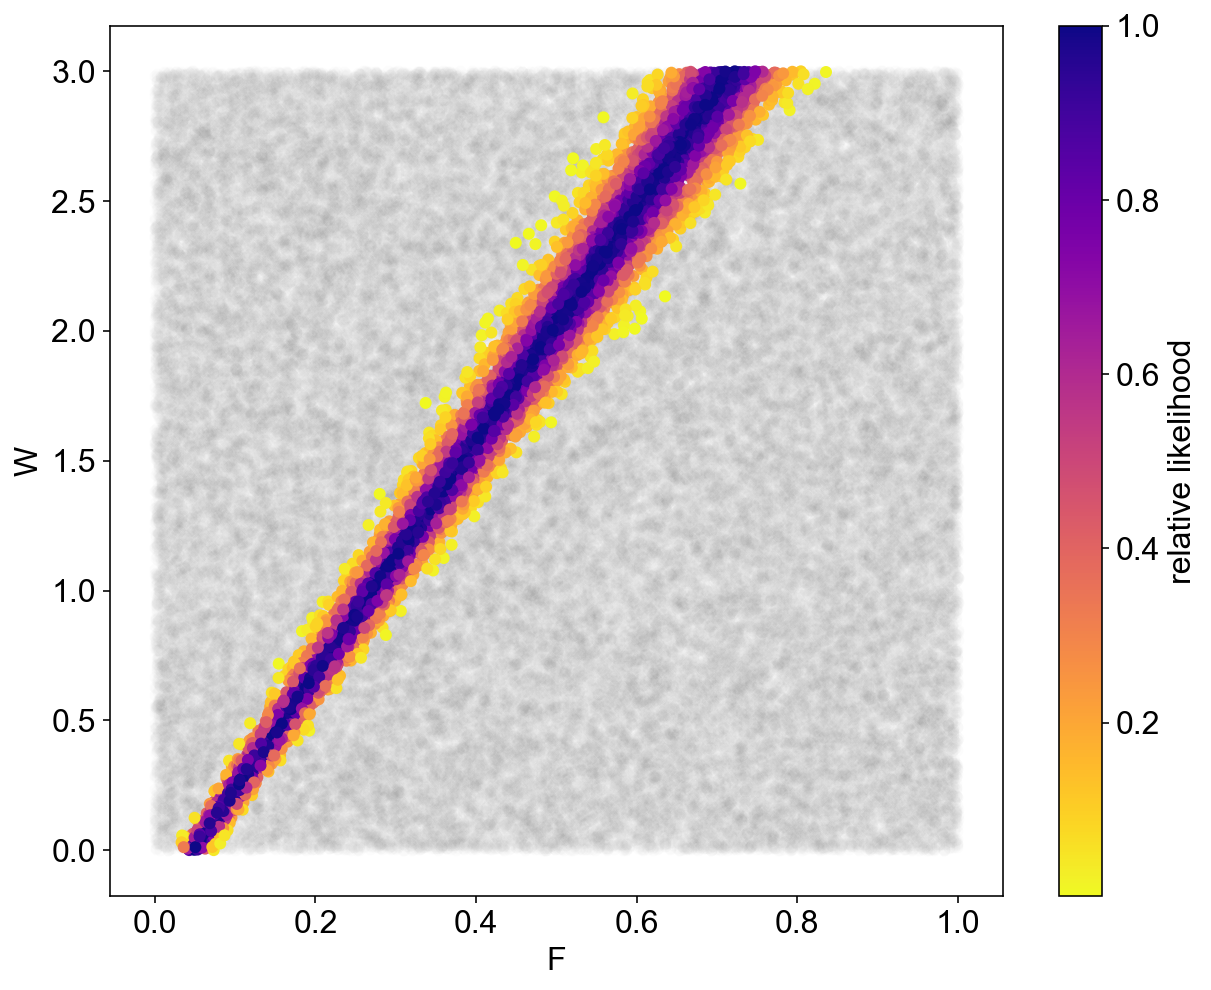

In [45]:
plt.figure(figsize=(10,8))

plt.scatter(priors.F, priors.W,
            c='grey', lw=0, alpha=0.02)

plt.scatter(posteriors.F, posteriors.W,
            c=posteriors.rel_likelihood,
            lw=0, cmap='plasma_r')

plt.colorbar(label='relative likelihood')

plt.xlabel('F')
plt.ylabel('W')

plt.show()

Now we see the dependence between $F$ and $W$, and it's pretty damn linear. We can also see that at high values, the range of acceptability is wider.

But this isn't the complete solution. $p(F,W\,|\,d)$ is a probability density function, and that means that (if we did everything correctly) the density of samples in the posterior represents the distribution. And the density of samples is just like population density: It's the number of samples per unit area, in this case in the $F-W$ plane shown above.

We can easily calculate and display this with a [kernel density estimate][kde] and plot with [seaborn][sns] in one line of code; we will also show the 'marginal' distributions on the sides:

[kde]: https://en.wikipedia.org/wiki/Kernel_density_estimation
[sns]: http://seaborn.pydata.org/

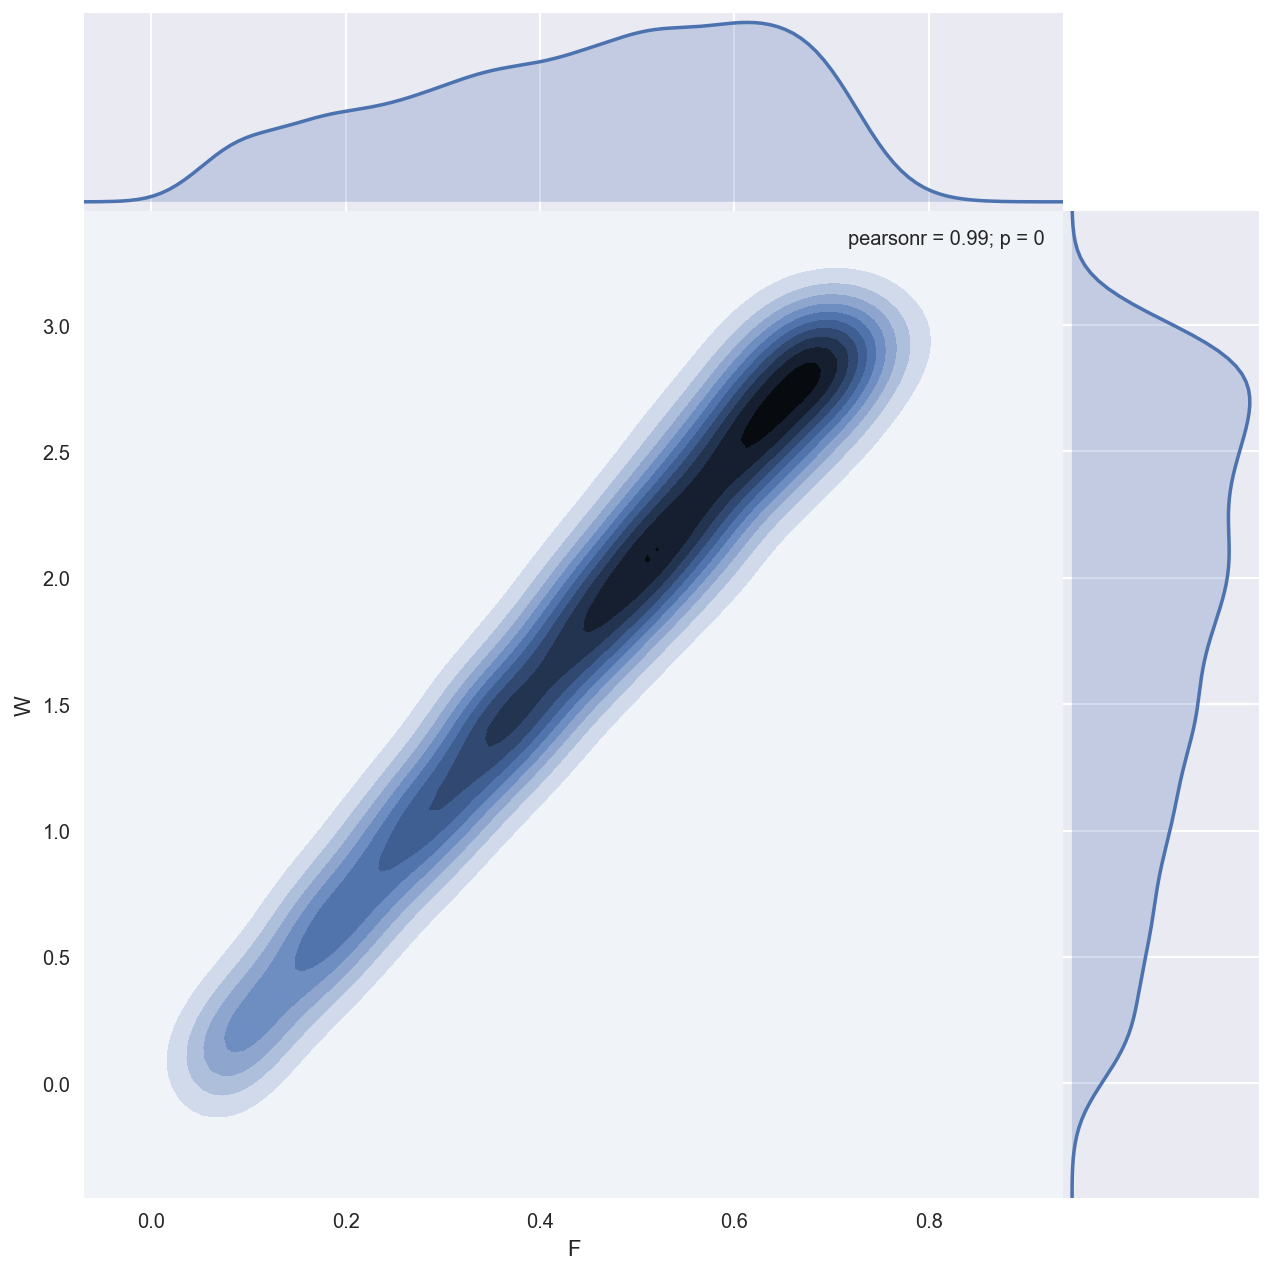

In [46]:
import seaborn as sns #didn't do it earlier 'cause it changes the plots
kde_plot = sns.jointplot(posteriors.F, posteriors.W, kind='kde', 
                         size=9, space=0)
plt.show()

The marginal distributions are the 1-d probability distributions of a joint probability distribution. This means that the other dimensions are all collapsed.  Therefore, if we want to know the posterior distribution of $F$, $p(F\,|\,d)$, we ignore that $W$ exists, and just look at the density estimate (i.e. a normalized histogram or KDE).

So that's it!

This gives us a good base to start with if we have additional information in the form of more narrow priors for $F$ or $W$, or if we have multiple sets of $\alpha$ and $\beta$ measurements. In that case, we can run the same calculations independently for each set of $\alpha$ and $\beta$ (i.e. each transect) and then calculate the joint distribution of the posteriors; this is really easy if you use a seeded random number generator to sample $F$ and $W$, or otherwise ensure that you're testing the same values for each inversion--then, to get the joint probability, you just find the samples that are in every posterior.  (I did this in a [JGR paper on topographic and tectonic stress in the Longmen Shan][jgr].)

[jgr]: http://onlinelibrary.wiley.com/doi/10.1002/2014JB011338/abstract